In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.special import erf
import pandas as pd

from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

In [2]:
def prepare_mother_list(filepath, Nevents=-1, random_state=1, make_plot=True):
    # read and add column names
    data = pd.read_csv(filepath, header=None, sep=' ')
    data.columns = ['Event', 'mJJ', 'mJ1', 'tau21J1', 'mJ2', 'tau21J2']
    data.set_index('Event', inplace=True)
    
    # select only Nevents number of events
    if 0 < Nevents <= len(data):
        data = data.sample(Nevents, random_state=random_state)
    elif Nevents > len(data):
        raise ValueError('request more events than provided')
    
    # remove nans and 0s, sort
    data = data[~np.any(np.isnan(data) | (data==0), axis=1)]
    data.sort_values(by='mJJ', inplace=True)
    
    # make mJ1 > mJ2 (and also swap tau_21 accordingly)
    data['mmax'] = np.max(data[['mJ1', 'mJ2']], axis=1)
    data['mmin'] = np.min(data[['mJ1', 'mJ2']], axis=1)
    J1ismax = data.mJ1 == data.mmax
    data['tau21max'] = data[J1ismax].tau21J1
    data.loc[~J1ismax, 'tau21max'] = data[~J1ismax].tau21J2
    data['tau21min'] = data[J1ismax].tau21J2
    data.loc[~J1ismax, 'tau21min'] = data[~J1ismax].tau21J1
    data.mJ1 = data.mmax
    data.mJ2 = data.mmin
    data.tau21J1 = data.tau21max
    data.tau21J2 = data.tau21min
    
    data.drop(columns = ['mmax', 'mmin', 'tau21max', 'tau21min'], inplace=True)
    
    print('retrieved array of shape {}'.format(data.shape))
    print(data.head())
    if make_plot:
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            hist_range = None
            if feature == 'mJ1':
                hist_range = (0, 750)
            elif feature == 'mJ2':
                hist_range = (0, 400)
            elif feature == 'mJJ':
                hist_range = (2000, 5000)
            axs[divmod(i, 3)].set_title(feature)
            axs[divmod(i, 3)].hist(data.iloc[:, i], density=True, bins=20, range=hist_range)
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.savefig('{}_distributions.png'.format(filepath))
        plt.show()

    return data

def prepare_data_train_signal(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    sublist=listcp[~mask]
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    
    return data_train[:,1:5],sublist[:,0]

def prepare_data_train_bkg(list_by_minv):
    
    sublist=np.copy(list_by_minv)   
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    data_train = tf.where(data_train <1.0, data_train, 1.0-1e-16)
    return data_train[:,1:5]

def prepare_data_train(M,deltaM,list_by_minv, ignore=None):
    if not ignore is None:
        if type(ignore) == str:
            ignore = [ignore]
        ignored = list_by_minv.loc[:, ignore]
        list_by_minv = list_by_minv.drop(columns = ignore)
    SR = (list_by_minv.mJJ > (M-deltaM)) & (list_by_minv.mJJ < (M+deltaM))

    #put the data on a unit hypercube and remove the edges
    hypercubemargin = 0.05
    minmax = list_by_minv.agg(['min', 'max'])
    # exact hypercube
    hcube = (list_by_minv - minmax.loc['min'])/(minmax.loc['max'] - minmax.loc['min'])
    # remove edges
    edge = (hcube < hypercubemargin).any(axis=1) | (hcube > 1-hypercubemargin).any(axis=1)
    print('efficiency in SR when cutting edges of hypercube: {:.2f}'.format(
        len(hcube[SR & ~edge])/len(hcube[SR])))
    if not ignore is None:
        hcube = pd.concat([hcube, ignored], axis=1)
    
    SBdata = hcube[~SR & ~edge].copy()
    SRdata = hcube[SR & ~edge].copy()
    SR_masses = list_by_minv[SR & ~edge].mJJ.values
    return tf.convert_to_tensor(SBdata.values), tf.convert_to_tensor(SRdata.values), SR_masses

def combine_sig_bkg(sig, bkg, make_plot=True):
    sig['signal'] = True
    bkg['signal'] = False
    
    combined = pd.concat([sig, bkg])
    if make_plot:
        div, mod = divmod(len(combined.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(combined.columns):
            hist_range = None
            if feature == 'mJ1':
                hist_range = (0, 750)
            elif feature == 'mJ2':
                hist_range = (0, 400)
            elif feature == 'mJJ':
                hist_range = (2000, 5000)
                
            axs[divmod(i, 3)].set_title(feature)
            if combined.iloc[:, i].dtype == 'bool':
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [len(combined[combined.signal]), 0],
                                      label='signal')
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [0, len(combined[~combined.signal])],
                                      label='background')
            else:
                axs[divmod(i, 3)].hist(combined[~combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='background', range=hist_range, bins=20)
                axs[divmod(i, 3)].hist(combined[combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='signal', range=hist_range, bins=20)
            axs[divmod(i, 3)].set_yscale('log')
            axs[divmod(i, 3)].set_ylabel('# events, stacked')
            if i == 0:
                axs[divmod(i, 3)].legend()
        plt.tight_layout()
        plt.show()
    
    return combined

In [3]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [4]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [5]:
def build_iflow(ndims,lr):
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    masks = np.concatenate((masks, masks, masks, masks))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=16,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(lr, clipnorm=10.0#, amsgrad=True
                                        )
    return dist, optimizer

In [6]:
@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no2(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no3(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [7]:
def save_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/model_layer_{:02d}'.format(j))

def load_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/model_layer_{:02d}'.format(j))
    print("Model loaded successfully")

In [8]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,lr=1e-3,epochs=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM,list_by_minv)
   
    if issig:
        data_train = sig
    else:
        data_train = bkg
        
    (totalpts, ndims) = np.shape(data_train)
    print(totalpts)
    
    dist, optimizer = build_iflow(ndims,lr) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize)
    print(batches)
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    for epoch in range(epochs+1):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches+1):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            try:
                loss = train_one_step(dist,optimizer,samples)
            except:
                try:
                    loss = train_one_step_no2(dist, optimizer, samples)
                except:
                    loss = train_one_step_no3(dist, optimizer, samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e}'.format(batch, loss))
        if epoch % 1 == 0:
            print('Epoch: {:3d} Loss = {:8e}'.format(epoch, loss))
    save_weights(dist)
    return dist

Import Data

retrieved array of shape (499940, 5)
            mJJ      mJ1   tau21J1       mJ2   tau21J2
Event                                                 
450885  1132.28  256.442  0.584751  122.0150  0.721372
925004  1483.28  179.502  0.607219   17.2407  0.705781
133206  1495.57  303.328  0.276508   80.7072  0.401215
733463  1511.23  340.636  0.243653   92.5361  0.796968
375308  1533.56  473.126  0.247497  141.8790  0.558868


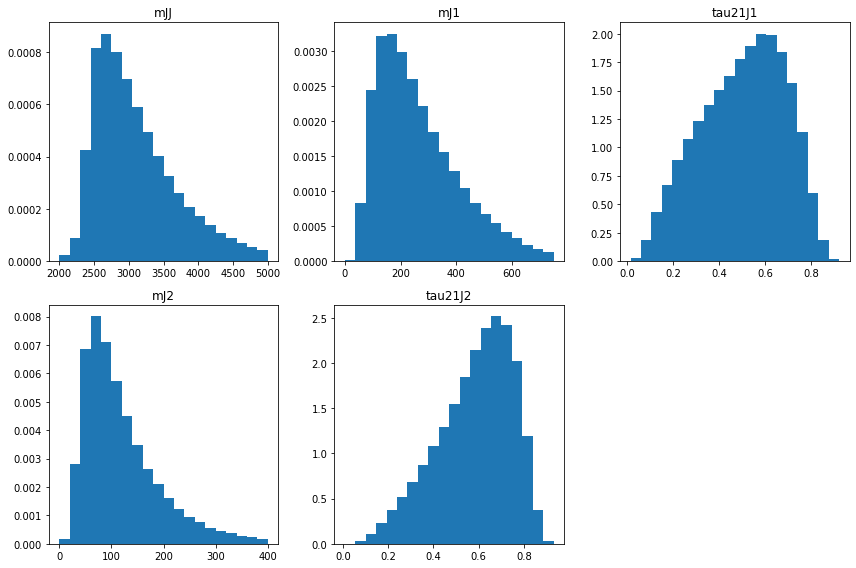

retrieved array of shape (500, 5)
           mJJ      mJ1   tau21J1       mJ2   tau21J2
Event                                                
16617  2328.29  502.652  0.059203  120.2820  0.741238
59906  2329.76  170.488  0.491438  102.9830  0.196261
17434  2438.02  539.559  0.206241  100.5230  0.255750
47859  2559.12  451.197  0.325897  125.6210  0.584055
98122  2755.21  416.224  0.174218   93.7666  0.240144


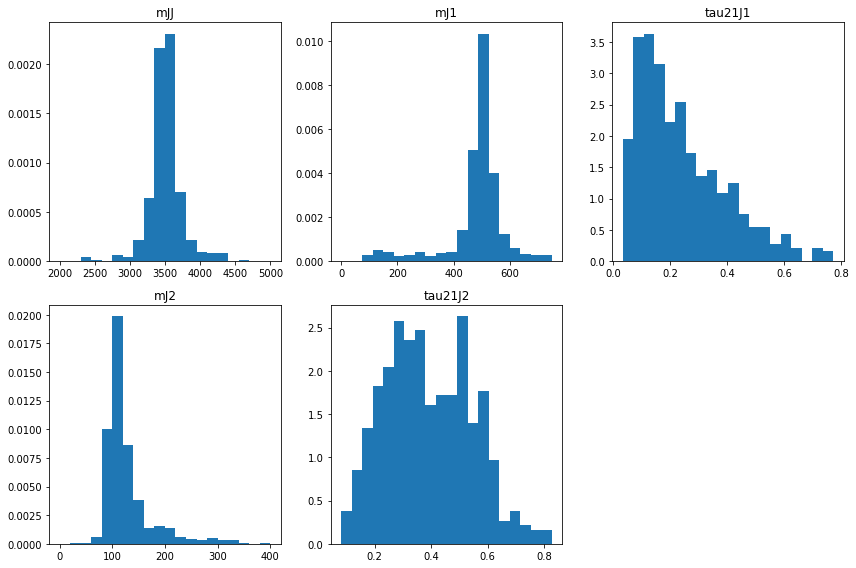

In [9]:
bkgname="rndbkgout.txt"
signame="rndsigout.txt"
bkglist=prepare_mother_list(bkgname, 500000, random_state=10)
siglist=prepare_mother_list(signame, 500, random_state=10)

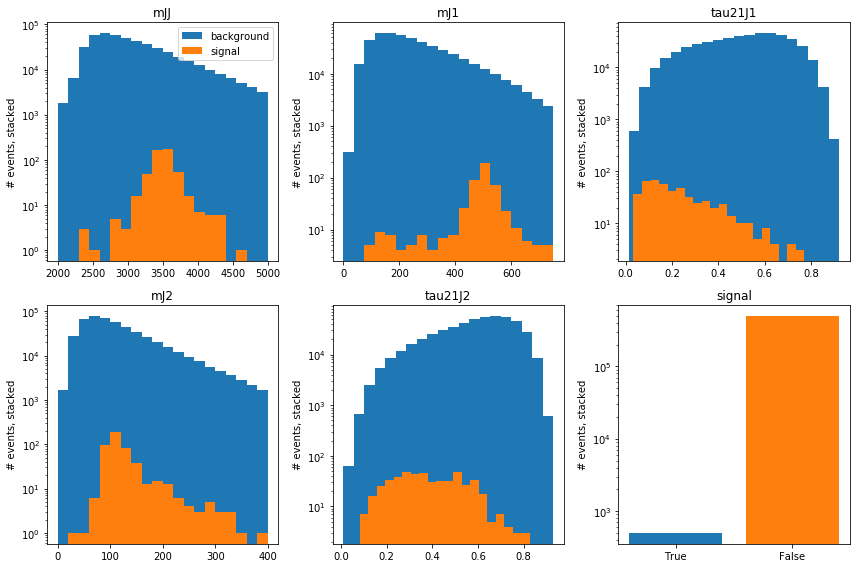

In [10]:
combined = combine_sig_bkg(siglist, bkglist)

In [11]:
Nsig_SR = combined.query('mJJ > 3300').query('mJJ < 3700').query('signal == 1').shape[0]
Nbkg_SR = combined.query('mJJ > 3300').query('mJJ < 3700').query('signal == 0').shape[0]
print('Nsig:', Nsig_SR)
print('Nbkg:', Nbkg_SR)
print('Nsig/Nbkg: {:.1e}'.format(Nsig_SR/Nbkg_SR))
print('Nsig/sqrt(Nbkg): {:.2f}'.format(Nsig_SR/np.sqrt(Nbkg_SR)))

Nsig: 381
Nbkg: 71331
Nsig/Nbkg: 5.3e-03
Nsig/sqrt(Nbkg): 1.43


Train on Signal Data

In [12]:
sigdist =train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                     issig=True, batchsize=256,lr=1e-4,epochs=10)

efficiency in SR when cutting edges of hypercube: 0.68
49000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32)                128       
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32)                128       
_________________________________________________________________
dense_38 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_66 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_33 (Batc (None, 32)                128       
_________________________________________________________________
dense_67 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_34 (Batc (None, 32)                128       
_________________________________________________________________
dense_68 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_69 (Dense)             (None, 32)                105

Batch:   0 Loss = 4.598946e-02
Batch:  10 Loss = -1.800493e-01
Batch:  20 Loss = -3.730878e-01
Batch:  30 Loss = -5.691594e-01
Batch:  40 Loss = -8.114361e-01
Batch:  50 Loss = -1.033760e+00
Batch:  60 Loss = -1.327251e+00
Batch:  70 Loss = -1.474092e+00
Batch:  80 Loss = -1.711718e+00
Batch:  90 Loss = -2.001648e+00
Batch: 100 Loss = -2.165883e+00
Batch: 110 Loss = -2.163681e+00
Batch: 120 Loss = -2.417362e+00
Batch: 130 Loss = -2.802790e+00
Batch: 140 Loss = -2.684594e+00
Batch: 150 Loss = -2.826164e+00
Batch: 160 Loss = -2.846091e+00
Batch: 170 Loss = -3.072539e+00
Batch: 180 Loss = -2.971527e+00
Batch: 190 Loss = -3.200402e+00
Epoch:   0 Loss = -3.119389e+00
Batch:   0 Loss = -2.999860e+00
Batch:  10 Loss = -3.074000e+00
Batch:  20 Loss = -3.228328e+00
Batch:  30 Loss = -3.125419e+00
Batch:  40 Loss = -3.242788e+00
Batch:  50 Loss = -3.197547e+00
Batch:  60 Loss = -3.350988e+00
Batch:  70 Loss = -3.448373e+00
Batch:  80 Loss = -3.374431e+00
Batch:  90 Loss = -3.436922e+00
Batch: 10

Train on Background Data

In [13]:
bkgdist = train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                      issig=False, batchsize=256,lr=1e-4,epochs=10) #do not use learning rate schedule

efficiency in SR when cutting edges of hypercube: 0.68
270594
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_96 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
dense_97 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_49 (Batc (None, 32)                128       
_________________________________________________________________
dense_98 (Dense)             (None, 32)                1056      
______________________________________________________________

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_126 (Dense)            (None, 32)                128       
_________________________________________________________________
batch_normalization_63 (Batc (None, 32)                128       
_________________________________________________________________
dense_127 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_64 (Batc (None, 32)                128       
_________________________________________________________________
dense_128 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_129 (Dense)            (None, 32)                105

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_162 (Dense)            (None, 32)                128       
_________________________________________________________________
batch_normalization_81 (Batc (None, 32)                128       
_________________________________________________________________
dense_163 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_82 (Batc (None, 32)                128       
_________________________________________________________________
dense_164 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_165 (Dense)            (None, 32)                105

Batch:   0 Loss = 5.700973e-02
Batch:  10 Loss = -1.932170e-01
Batch:  20 Loss = -3.899055e-01
Batch:  30 Loss = -6.277274e-01
Batch:  40 Loss = -8.168495e-01
Batch:  50 Loss = -1.034706e+00
Batch:  60 Loss = -1.261555e+00
Batch:  70 Loss = -1.384139e+00
Batch:  80 Loss = -1.680868e+00
Batch:  90 Loss = -1.922998e+00
Batch: 100 Loss = -2.155491e+00
Batch: 110 Loss = -2.467198e+00
Batch: 120 Loss = -2.756953e+00
Batch: 130 Loss = -2.746824e+00
Batch: 140 Loss = -2.609778e+00
Batch: 150 Loss = -3.072353e+00
Batch: 160 Loss = -3.021110e+00
Batch: 170 Loss = -3.111055e+00
Batch: 180 Loss = -3.086288e+00
Batch: 190 Loss = -3.139347e+00
Batch: 200 Loss = -3.310361e+00
Batch: 210 Loss = -3.322565e+00
Batch: 220 Loss = -3.496119e+00
Batch: 230 Loss = -3.563344e+00
Batch: 240 Loss = -3.443090e+00
Batch: 250 Loss = -3.500470e+00
Batch: 260 Loss = -3.619648e+00
Batch: 270 Loss = -3.529618e+00
Batch: 280 Loss = -3.459748e+00
Batch: 290 Loss = -3.636478e+00
Batch: 300 Loss = -3.406114e+00
Batch: 31

Batch: 420 Loss = -4.238436e+00
Batch: 430 Loss = -4.378396e+00
Batch: 440 Loss = -4.147727e+00
Batch: 450 Loss = -4.312684e+00
Batch: 460 Loss = -4.123462e+00
Batch: 470 Loss = -4.030817e+00
Batch: 480 Loss = -4.164294e+00
Batch: 490 Loss = -4.216525e+00
Batch: 500 Loss = -4.200722e+00
Batch: 510 Loss = -4.145124e+00
Batch: 520 Loss = -4.140549e+00
Batch: 530 Loss = -4.220357e+00
Batch: 540 Loss = -4.071177e+00
Batch: 550 Loss = -4.088928e+00
Batch: 560 Loss = -4.111729e+00
Batch: 570 Loss = -4.183461e+00
Batch: 580 Loss = -4.219895e+00
Batch: 590 Loss = -4.219085e+00
Batch: 600 Loss = -4.396664e+00
Batch: 610 Loss = -4.220232e+00
Batch: 620 Loss = -4.035780e+00
Batch: 630 Loss = -4.316817e+00
Batch: 640 Loss = -4.331661e+00
Batch: 650 Loss = -4.083206e+00
Batch: 660 Loss = -4.076140e+00
Batch: 670 Loss = -4.300327e+00
Batch: 680 Loss = -4.263399e+00
Batch: 690 Loss = -4.183152e+00
Batch: 700 Loss = -4.210742e+00
Batch: 710 Loss = -4.120975e+00
Batch: 720 Loss = -4.193698e+00
Batch: 7

Batch: 840 Loss = -4.311728e+00
Batch: 850 Loss = -4.199974e+00
Batch: 860 Loss = -4.169756e+00
Batch: 870 Loss = -4.199095e+00
Batch: 880 Loss = -4.307263e+00
Batch: 890 Loss = -4.275323e+00
Batch: 900 Loss = -4.095564e+00
Batch: 910 Loss = -4.428018e+00
Batch: 920 Loss = -4.108285e+00
Batch: 930 Loss = -4.253346e+00
Batch: 940 Loss = -4.169142e+00
Batch: 950 Loss = -4.177439e+00
Batch: 960 Loss = -4.124122e+00
Batch: 970 Loss = -4.243834e+00
Batch: 980 Loss = -4.244368e+00
Batch: 990 Loss = -4.173309e+00
Batch: 1000 Loss = -4.345409e+00
Batch: 1010 Loss = -4.208079e+00
Batch: 1020 Loss = -4.222823e+00
Batch: 1030 Loss = -4.394195e+00
Batch: 1040 Loss = -4.200806e+00
Batch: 1050 Loss = -4.338628e+00
Epoch:   4 Loss = -2.775484e+00
Batch:   0 Loss = -4.150217e+00
Batch:  10 Loss = -4.295416e+00
Batch:  20 Loss = -4.395512e+00
Batch:  30 Loss = -4.186029e+00
Batch:  40 Loss = -4.326810e+00
Batch:  50 Loss = -4.273446e+00
Batch:  60 Loss = -4.037853e+00
Batch:  70 Loss = -4.273065e+00
Ba

Batch: 190 Loss = -4.021618e+00
Batch: 200 Loss = -4.260499e+00
Batch: 210 Loss = -4.290412e+00
Batch: 220 Loss = -4.221896e+00
Batch: 230 Loss = -4.243344e+00
Batch: 240 Loss = -4.262293e+00
Batch: 250 Loss = -4.340235e+00
Batch: 260 Loss = -4.067695e+00
Batch: 270 Loss = -4.355689e+00
Batch: 280 Loss = -4.242707e+00
Batch: 290 Loss = -4.408720e+00
Batch: 300 Loss = -4.263954e+00
Batch: 310 Loss = -4.168874e+00
Batch: 320 Loss = -4.180060e+00
Batch: 330 Loss = -4.037953e+00
Batch: 340 Loss = -4.323121e+00
Batch: 350 Loss = -4.407093e+00
Batch: 360 Loss = -4.116671e+00
Batch: 370 Loss = -4.254135e+00
Batch: 380 Loss = -4.253491e+00
Batch: 390 Loss = -4.138787e+00
Batch: 400 Loss = -4.120179e+00
Batch: 410 Loss = -4.265400e+00
Batch: 420 Loss = -4.185060e+00
Batch: 430 Loss = -4.291188e+00
Batch: 440 Loss = -4.190777e+00
Batch: 450 Loss = -4.144445e+00
Batch: 460 Loss = -4.374183e+00
Batch: 470 Loss = -4.141914e+00
Batch: 480 Loss = -4.268367e+00
Batch: 490 Loss = -4.337174e+00
Batch: 5

Batch: 610 Loss = -4.244568e+00
Batch: 620 Loss = -4.297306e+00
Batch: 630 Loss = -4.296015e+00
Batch: 640 Loss = -4.156156e+00
Batch: 650 Loss = -4.388411e+00
Batch: 660 Loss = -4.386573e+00
Batch: 670 Loss = -4.385991e+00
Batch: 680 Loss = -4.143475e+00
Batch: 690 Loss = -4.138719e+00
Batch: 700 Loss = -4.242307e+00
Batch: 710 Loss = -4.184792e+00
Batch: 720 Loss = -4.366210e+00
Batch: 730 Loss = -4.267545e+00
Batch: 740 Loss = -4.260652e+00
Batch: 750 Loss = -4.293707e+00
Batch: 760 Loss = -4.170105e+00
Batch: 770 Loss = -4.068406e+00
Batch: 780 Loss = -4.420014e+00
Batch: 790 Loss = -4.174382e+00
Batch: 800 Loss = -4.291484e+00
Batch: 810 Loss = -4.220673e+00
Batch: 820 Loss = -4.293274e+00
Batch: 830 Loss = -4.162586e+00
Batch: 840 Loss = -4.250132e+00
Batch: 850 Loss = -4.195961e+00
Batch: 860 Loss = -4.094640e+00
Batch: 870 Loss = -4.399098e+00
Batch: 880 Loss = -4.237153e+00
Batch: 890 Loss = -4.284704e+00
Batch: 900 Loss = -4.238675e+00
Batch: 910 Loss = -4.209725e+00
Batch: 9

Calculating R

In [17]:
combined.signal = combined.signal.astype(float)
data_train_bkg, data_train_sig, invM= prepare_data_train(3500,200, combined, ignore='signal')

efficiency in SR when cutting edges of hypercube: 0.68


In [18]:
bkgprob=bkgdist.prob(data_train_sig[:, :5])
sigprob=sigdist.prob(data_train_sig[:, :5])
bkglogprob=np.log(bkgprob)

cast back into pandas DataFrames

In [19]:
data_train_sig = pd.DataFrame(data_train_sig.numpy(), columns=['mJJ', 'mJ1', 'tau21J1', 'mJ2', 'tau21J2', 'signal'])
data_train_sig.signal = (data_train_sig.signal - np.min(data_train_sig.signal)).astype('bool')
data_train_sig['sigprob'] = sigprob.numpy()
data_train_sig['bkgprob'] = bkgprob.numpy()
data_train_sig['bkglogprob'] = np.log(data_train_sig['bkgprob'])
data_train_sig['R'] = data_train_sig.sigprob/data_train_sig.bkgprob
data_train_sig['mJJ_unscaled'] = invM
data_train_sig.sort_values(by='R', ascending=True, inplace=True)
issignal = data_train_sig.signal

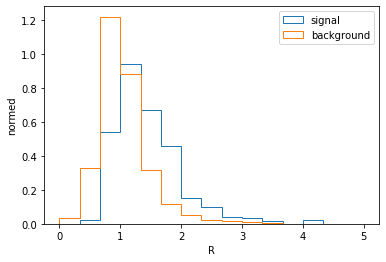

In [20]:
plt.hist(data_train_sig[issignal].R,
         bins=15, range=(0,5), histtype='step', density=True, label='signal')
plt.hist(data_train_sig[~issignal].R,
         bins=15, range=(0,5), histtype='step', density=True, label='background')
plt.xlabel('R')
plt.ylabel('normed')
plt.legend()
plt.savefig('R_distribution.png')
plt.show()

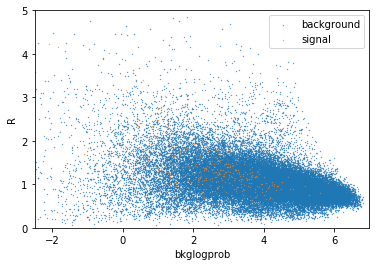

In [21]:
plt.scatter(data_train_sig[~issignal].bkglogprob, data_train_sig[~issignal].R, s=0.1, label='background')
plt.scatter(data_train_sig[issignal].bkglogprob, data_train_sig[issignal].R, s=0.1, label='signal')
plt.ylim(0,5)
plt.xlim(-2.5,7)
plt.xlabel('bkglogprob')
plt.ylabel('R')
plt.legend()
plt.savefig('R_bkglogprob_scatter.png')
plt.show()

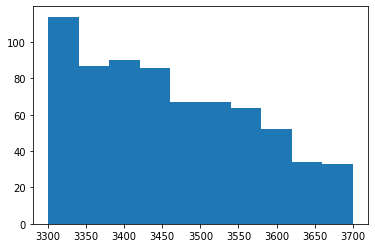

In [23]:
plt.hist(data_train_sig.query('R > 2.5').mJJ_unscaled)
plt.show()

In [24]:
signals = data_train_sig[issignal].copy()
signals.sort_values(by='R', ascending=False, inplace=True)
signals['count'] = np.arange(len(signals))

backgrounds = data_train_sig[~issignal].copy()
backgrounds.sort_values(by='R', ascending=False, inplace=True)
backgrounds['count'] = np.arange(len(backgrounds))

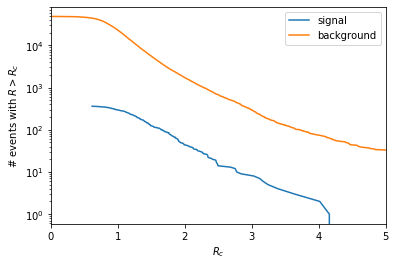

In [25]:
plt.plot(signals.R, signals['count'], label='signal')
plt.plot(backgrounds.R, backgrounds['count'], label='background')
plt.yscale('log')
plt.ylabel('# events with $R > R_c$')
plt.xlabel('$R_c$')
plt.xlim(0,5)
plt.legend()
plt.savefig('Events_vs_Rc.png')
plt.show()

In [26]:
effs = pd.DataFrame(np.linspace(0, 5, 50), columns=['Rmin'])
effs['sig_eff'] = effs.Rmin.transform(lambda x: len(signals.query('R > {}'.format(x)))/Nsig_SR)
effs['bkg_rej'] = effs.Rmin.transform(lambda x: Nbkg_SR/len(backgrounds.query('R > {}'.format(x))))
effs['s_over_sqrtb'] = effs.sig_eff * np.sqrt(effs.bkg_rej)

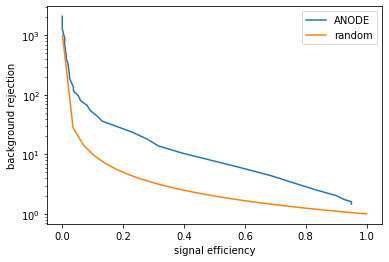

In [27]:
plt.plot(effs.sig_eff, effs.bkg_rej, label='ANODE')
plt.plot(np.linspace(0.001, 1, 30), 1/np.linspace(0.001, 1, 30), label='random')
plt.yscale('log')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend()
plt.savefig('ROC.png')
plt.show()

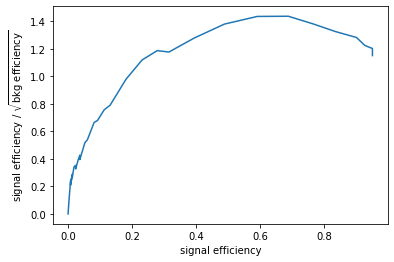

In [28]:
plt.plot(effs.sig_eff, effs.s_over_sqrtb)
plt.xlabel('signal efficiency')
plt.ylabel('signal efficiency / $\sqrt{\mathrm{bkg~efficiency}}$')
plt.show()

In [71]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

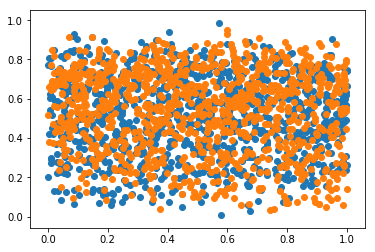

In [74]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [36]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

NameError: name 'training_data_sampled' is not defined